In [48]:
import os
import attacks
import numpy as np
import torch
# from utils.matching_modified_1 import match_reconstruction_ground_truth
from utils.matching import match_reconstruction_ground_truth
import pandas as pd
from utils import Timer, post_process_continuous
from attacks import train_and_attack_fed_avg
from models import FullyConnected
import matplotlib.pyplot as plt
import argparse
import pickle
from attacks import calculate_random_baseline
# from datasets.adult_modified import ADULT
from datasets.base_dataset import BaseDataset


In [2]:
configs = {
    # Inverting Gradients
    0: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 1,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': None,
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': False,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': False,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    },
    # TabLeak
    52: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 15,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': 'median',
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': True,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': True,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    }
}

In [3]:
client_models = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
               "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
               "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
               "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
               "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# client_models = ["AL","AK"]

# testing_data=["WM","WW","BM","BW"]

In [4]:
gt_info=pd.read_csv('50_clients_data/state_sex_race_counts.csv')
gt_info.head()

,State,Male_Count,Female_Count,White_Count,Black_Count
0,AL,1038,962,1588,412
1,AK,1129,871,1932,68
2,AZ,1052,948,1912,88
3,AR,1026,974,1807,193
4,CA,1070,930,1856,144


In [5]:


def group_filter(client_gt_projected, client_recon_projected, index, value):
    # print("group_filter applied")
    print("index: ",index, "value: ",value)
    filtered_gt = client_gt_projected[client_gt_projected[:, index] == value]
    filtered_recon = client_recon_projected[client_gt_projected[:, index] == value]
    return filtered_gt, filtered_recon


def subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2):
    # print("subgroup_filter applied")
    print("index1: ", index1,"value1: ", value1, "index2: ",index2,"value2: ", value2)
    condition = (client_gt_projected[:, index1] == value1) & (client_gt_projected[:, index2] == value2)
    filtered_gt = client_gt_projected[condition]
    filtered_recon = client_recon_projected[condition]
    return filtered_gt, filtered_recon


# Normal

In [6]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    recn_gt = f'../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    tolerance_map = f'../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, 1),(8, 2), (9, 1), (9, 2)]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  AL
(2000, 10) (2000, 10)
index:  8 value:  1
(1037, 10) (1037, 10)
index:  8 value:  2
(963, 10) (963, 10)
index:  9 value:  1
(1587, 10) (1587, 10)
index:  9 value:  2
(413, 10) (413, 10)
----------- Model_name --------------:  AK
(2000, 10) (2000, 10)
index:  8 value:  1
(1140, 10) (1140, 10)
index:  8 value:  2
(860, 10) (860, 10)
index:  9 value:  1
(1933, 10) (1933, 10)
index:  9 value:  2
(67, 10) (67, 10)
----------- Model_name --------------:  AZ
(2000, 10) (2000, 10)
index:  8 value:  1
(1064, 10) (1064, 10)
index:  8 value:  2
(936, 10) (936, 10)
index:  9 value:  1
(1911, 10) (1911, 10)
index:  9 value:  2
(89, 10) (89, 10)
----------- Model_name --------------:  AR
(2000, 10) (2000, 10)
index:  8 value:  1
(1032, 10) (1032, 10)
index:  8 value:  2
(968, 10) (968, 10)
index:  9 value:  1
(1809, 10) (1809, 10)
index:  9 value:  2
(191, 10) (191, 10)
----------- Model_name --------------:  CA
(2000, 10) (2000, 10)

In [7]:
final_all_errors_full

[[0.3227727272727272],
 [0.3154545454545454],
 [0.2970454545454545],
 [0.26918181818181813],
 [0.3101363636363636],
 [0.2990454545454545],
 [0.3349090909090908],
 [0.3171363636363636],
 [0.29618181818181816],
 [0.32027272727272726],
 [0.3279090909090909],
 [0.2777272727272727],
 [0.29572727272727267],
 [0.2991363636363636],
 [0.30895454545454537],
 [0.2986818181818181],
 [0.2976818181818181],
 [0.2962272727272726],
 [0.29981818181818176],
 [0.32713636363636356],
 [0.3159545454545454],
 [0.3114999999999999],
 [0.30031818181818176],
 [0.31386363636363634],
 [0.2904545454545454],
 [0.29695454545454536],
 [0.29786363636363633],
 [0.28518181818181815],
 [0.2840454545454545],
 [0.35281818181818175],
 [0.2788636363636363],
 [0.32881818181818173],
 [0.30331818181818176],
 [0.3006818181818181],
 [0.3106818181818181],
 [0.3128181818181818],
 [0.30095454545454536],
 [0.30813636363636354],
 [0.2972727272727272],
 [0.3117727272727272],
 [0.2956363636363636],
 [0.30990909090909086],
 [0.289863636363

In [8]:
final_all_errors

[[[0.39098798983080557],
  [0.3410742943453223],
  [0.3386034255599473],
  [0.4160246533127889]],
 [[0.35382775119617227],
  [0.3597251585623678],
  [0.315336500023515],
  [0.5115332428765266]],
 [[0.34996582365003415],
  [0.3319735819735819],
  [0.29389657961086524],
  [0.47599591419816134]],
 [[0.32522903453136004],
  [0.30315552216378655],
  [0.27207397356651086],
  [0.4150404569252737]],
 [[0.35636705721371753],
  [0.3568448627146598],
  [0.3109120281979732],
  [0.46408137317228226]],
 [[0.3341337907375643],
  [0.3450676982591876],
  [0.29709804658151756],
  [0.4914772727272727]],
 [[0.3814918879724462],
  [0.37074860946475785],
  [0.33631368631368624],
  [0.47878787878787865]],
 [[0.36071851919394543],
  [0.3591951418471856],
  [0.3224771639843409],
  [0.42378048780487804]],
 [[0.35486443381180216],
  [0.3302221392570468],
  [0.30533877719778796],
  [0.41305167861184455]],
 [[0.37389458790236996],
  [0.3571829405162738],
  [0.34084749938408476],
  [0.40145732130464945]],
 [[0.3690

In [9]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [10]:
all_state_recon

{'AL': 67.72272727272728,
 'AK': 68.45454545454545,
 'AZ': 70.29545454545455,
 'AR': 73.08181818181818,
 'CA': 68.98636363636363,
 'CO': 70.09545454545454,
 'CT': 66.50909090909092,
 'DE': 68.28636363636365,
 'FL': 70.38181818181819,
 'GA': 67.97272727272727,
 'HI': 67.2090909090909,
 'ID': 72.22727272727273,
 'IL': 70.42727272727274,
 'IN': 70.08636363636364,
 'IA': 69.10454545454546,
 'KS': 70.13181818181819,
 'KY': 70.23181818181818,
 'LA': 70.37727272727274,
 'ME': 70.01818181818183,
 'MD': 67.28636363636365,
 'MA': 68.40454545454546,
 'MI': 68.85000000000001,
 'MN': 69.96818181818183,
 'MS': 68.61363636363636,
 'MO': 70.95454545454545,
 'MT': 70.30454545454546,
 'NE': 70.21363636363637,
 'NV': 71.48181818181818,
 'NH': 71.59545454545454,
 'NJ': 64.71818181818183,
 'NM': 72.11363636363637,
 'NY': 67.11818181818184,
 'NC': 69.66818181818182,
 'ND': 69.9318181818182,
 'OH': 68.93181818181819,
 'OK': 68.71818181818182,
 'OR': 69.90454545454547,
 'PA': 69.18636363636365,
 'RI': 70.2727

In [11]:
filename_all_state_inversion = "inversion_normal_all_states_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_normal_all_states_reconstruction.pickle


In [12]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print(all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }



[[0.39098798983080557], [0.3410742943453223], [0.3386034255599473], [0.4160246533127889]]
[[0.35382775119617227], [0.3597251585623678], [0.315336500023515], [0.5115332428765266]]
[[0.34996582365003415], [0.3319735819735819], [0.29389657961086524], [0.47599591419816134]]
[[0.32522903453136004], [0.30315552216378655], [0.27207397356651086], [0.4150404569252737]]
[[0.35636705721371753], [0.3568448627146598], [0.3109120281979732], [0.46408137317228226]]
[[0.3341337907375643], [0.3450676982591876], [0.29709804658151756], [0.4914772727272727]]
[[0.3814918879724462], [0.37074860946475785], [0.33631368631368624], [0.47878787878787865]]
[[0.36071851919394543], [0.3591951418471856], [0.3224771639843409], [0.42378048780487804]]
[[0.35486443381180216], [0.3302221392570468], [0.30533877719778796], [0.41305167861184455]]
[[0.37389458790236996], [0.3571829405162738], [0.34084749938408476], [0.40145732130464945]]
[[0.3690660874961216], [0.3681379007465963], [0.3240043057050592], [0.5166453265044814]]


In [13]:
final_group_reco

{'AL': {'Male': 60.90120101691945,
  'Female': 65.89257056546776,
  'White': 66.13965744400528,
  'Black': 58.39753466872111},
 'AK': {'Male': 64.61722488038278,
  'Female': 64.02748414376322,
  'White': 68.4663499976485,
  'Black': 48.84667571234734},
 'AZ': {'Male': 65.00341763499658,
  'Female': 66.80264180264182,
  'White': 70.61034203891347,
  'Black': 52.400408580183864},
 'AR': {'Male': 67.477096546864,
  'Female': 69.68444778362135,
  'White': 72.79260264334891,
  'Black': 58.49595430747263},
 'CA': {'Male': 64.36329427862825,
  'Female': 64.31551372853401,
  'White': 68.90879718020268,
  'Black': 53.591862682771776},
 'CO': {'Male': 66.58662092624357,
  'Female': 65.49323017408125,
  'White': 70.29019534184823,
  'Black': 50.85227272727273},
 'CT': {'Male': 61.850811202755374,
  'Female': 62.92513905352421,
  'White': 66.36863136863138,
  'Black': 52.12121212121213},
 'DE': {'Male': 63.92814808060545,
  'Female': 64.08048581528143,
  'White': 67.7522836015659,
  'Black': 57.62

In [14]:

filename_all_state_inversion_group = "inversion_normal_group_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_normal_group_reconstruction.pickle


# DP

In [15]:
exp2 = "tableak_FT_inversion_DP"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion DP attack")

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    recn_gt = f'../{exp2}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../{exp2}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    tolerance_map = f'../{exp2}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, 1),(8, 2), (9, 1), (9, 2)]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion DP attack
----------- Model_name --------------:  AL
(2000, 10) (2000, 10)
index:  8 value:  1
(1037, 10) (1037, 10)
index:  8 value:  2
(963, 10) (963, 10)
index:  9 value:  1
(1587, 10) (1587, 10)
index:  9 value:  2
(413, 10) (413, 10)
----------- Model_name --------------:  AK
(2000, 10) (2000, 10)
index:  8 value:  1
(1140, 10) (1140, 10)
index:  8 value:  2
(860, 10) (860, 10)
index:  9 value:  1
(1933, 10) (1933, 10)
index:  9 value:  2
(67, 10) (67, 10)
----------- Model_name --------------:  AZ
(2000, 10) (2000, 10)
index:  8 value:  1
(1064, 10) (1064, 10)
index:  8 value:  2
(936, 10) (936, 10)
index:  9 value:  1
(1911, 10) (1911, 10)
index:  9 value:  2
(89, 10) (89, 10)
----------- Model_name --------------:  AR
(2000, 10) (2000, 10)
index:  8 value:  1
(1032, 10) (1032, 10)
index:  8 value:  2
(968, 10) (968, 10)
index:  9 value:  1
(1809, 10) (1809, 10)
index:  9 value:  2
(191, 10) (191, 10)
----------- Model_name --------------:  CA
(2000, 10) (2000, 10)
ind

In [16]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var


In [17]:
all_state_recon

{'AL': 60.20454545454545,
 'AK': 62.404545454545456,
 'AZ': 64.08636363636364,
 'AR': 62.80000000000001,
 'CA': 58.750000000000014,
 'CO': 64.43181818181817,
 'CT': 60.62727272727273,
 'DE': 63.19545454545455,
 'FL': 64.40909090909092,
 'GA': 61.795454545454554,
 'HI': 59.818181818181834,
 'ID': 63.76363636363638,
 'IL': 65.62272727272729,
 'IN': 58.936363636363645,
 'IA': 63.21363636363637,
 'KS': 61.88636363636364,
 'KY': 62.477272727272734,
 'LA': 64.06363636363636,
 'ME': 63.09545454545456,
 'MD': 50.82727272727274,
 'MA': 49.395454545454555,
 'MI': 61.62727272727273,
 'MN': 63.93181818181819,
 'MS': 59.58181818181819,
 'MO': 61.76363636363638,
 'MT': 62.313636363636384,
 'NE': 63.84545454545455,
 'NV': 64.90909090909092,
 'NH': 64.63636363636365,
 'NJ': 56.72272727272728,
 'NM': 66.33636363636364,
 'NY': 62.3409090909091,
 'NC': 61.977272727272734,
 'ND': 64.54545454545455,
 'OH': 60.90454545454547,
 'OK': 58.93636363636365,
 'OR': 65.23181818181818,
 'PA': 62.209090909090925,
 'R

In [18]:
all_state_inversion_dp = "inversion_dp_all_states_reconstruction.pickle"

with open(all_state_inversion_dp, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data(DP) has been stored in {all_state_inversion_dp}")

All state reconstructed data(DP) has been stored in inversion_dp_all_states_reconstruction.pickle


In [19]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    # print(all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }


final_group_reco      

{'AL': {'Male': 54.39642324888227,
  'Female': 58.557537996790344,
  'White': 58.42355502090852,
  'Black': 53.819062293638574},
 'AK': {'Male': 57.631578947368425,
  'Female': 58.805496828752645,
  'White': 62.23486808070358,
  'Black': 45.590230664857536},
 'AZ': {'Male': 58.74060150375939,
  'Female': 61.363636363636374,
  'White': 63.859949574235294,
  'Black': 48.518896833503575},
 'AR': {'Male': 57.89288231148697,
  'Female': 59.47595792637116,
  'White': 62.01316649077844,
  'Black': 52.87958115183247},
 'CA': {'Male': 53.784315402377494,
  'Female': 56.04928689240323,
  'White': 58.226856611347735,
  'Black': 48.76033057851241},
 'CO': {'Male': 59.305317324185246,
  'Female': 61.170212765957466,
  'White': 64.2796769346356,
  'Black': 47.44318181818182},
 'CT': {'Male': 55.089277621680424,
  'Female': 57.64566426552386,
  'White': 59.99000999001001,
  'Black': 49.54545454545455},
 'DE': {'Male': 57.791556487644755,
  'Female': 60.58189069156168,
  'White': 61.6300565463245,
  '

In [20]:
final_group_reco

{'AL': {'Male': 54.39642324888227,
  'Female': 58.557537996790344,
  'White': 58.42355502090852,
  'Black': 53.819062293638574},
 'AK': {'Male': 57.631578947368425,
  'Female': 58.805496828752645,
  'White': 62.23486808070358,
  'Black': 45.590230664857536},
 'AZ': {'Male': 58.74060150375939,
  'Female': 61.363636363636374,
  'White': 63.859949574235294,
  'Black': 48.518896833503575},
 'AR': {'Male': 57.89288231148697,
  'Female': 59.47595792637116,
  'White': 62.01316649077844,
  'Black': 52.87958115183247},
 'CA': {'Male': 53.784315402377494,
  'Female': 56.04928689240323,
  'White': 58.226856611347735,
  'Black': 48.76033057851241},
 'CO': {'Male': 59.305317324185246,
  'Female': 61.170212765957466,
  'White': 64.2796769346356,
  'Black': 47.44318181818182},
 'CT': {'Male': 55.089277621680424,
  'Female': 57.64566426552386,
  'White': 59.99000999001001,
  'Black': 49.54545454545455},
 'DE': {'Male': 57.791556487644755,
  'Female': 60.58189069156168,
  'White': 61.6300565463245,
  '

In [21]:

all_state_inversion_group_dp = "inversion_dp_group_reconstruction.pickle"

with open(all_state_inversion_group_dp, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data (DP) has been stored in {all_state_inversion_group_dp}")

Group reconstructed data (DP) has been stored in inversion_dp_group_reconstruction.pickle


# Fair -- Intersectional

In [22]:
exp3 = "tableak_FT_inversion_fair"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Fair attack")

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    recn_gt = f'../{exp3}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../{exp3}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    tolerance_map = f'../{exp3}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, 1),(8, 2), (9, 1), (9, 2)]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Fair attack
----------- Model_name --------------:  AL
(2000, 10) (2000, 10)
index:  8 value:  1
(1037, 10) (1037, 10)
index:  8 value:  2
(963, 10) (963, 10)
index:  9 value:  1
(1587, 10) (1587, 10)
index:  9 value:  2
(413, 10) (413, 10)
----------- Model_name --------------:  AK
(2000, 10) (2000, 10)
index:  8 value:  1
(1140, 10) (1140, 10)
index:  8 value:  2
(860, 10) (860, 10)
index:  9 value:  1
(1933, 10) (1933, 10)
index:  9 value:  2
(67, 10) (67, 10)
----------- Model_name --------------:  AZ
(2000, 10) (2000, 10)
index:  8 value:  1
(1064, 10) (1064, 10)
index:  8 value:  2
(936, 10) (936, 10)
index:  9 value:  1
(1911, 10) (1911, 10)
index:  9 value:  2
(89, 10) (89, 10)
----------- Model_name --------------:  AR
(2000, 10) (2000, 10)
index:  8 value:  1
(1032, 10) (1032, 10)
index:  8 value:  2
(968, 10) (968, 10)
index:  9 value:  1
(1809, 10) (1809, 10)
index:  9 value:  2
(191, 10) (191, 10)
----------- Model_name --------------:  CA
(2000, 10) (2000, 10)
i

In [23]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var


In [24]:
all_state_recon

{'AL': 61.06363636363636,
 'AK': 56.85909090909092,
 'AZ': 61.06363636363638,
 'AR': 62.21363636363637,
 'CA': 61.804545454545455,
 'CO': 61.4318181818182,
 'CT': 49.26363636363638,
 'DE': 63.663636363636364,
 'FL': 65.30454545454546,
 'GA': 64.52272727272728,
 'HI': 55.168181818181814,
 'ID': 67.8409090909091,
 'IL': 64.70000000000002,
 'IN': 61.02272727272727,
 'IA': 63.71818181818183,
 'KS': 55.327272727272735,
 'KY': 64.20909090909092,
 'LA': 63.86363636363637,
 'ME': 70.14545454545456,
 'MD': 61.136363636363654,
 'MA': 60.136363636363654,
 'MI': 64.77727272727275,
 'MN': 54.88181818181819,
 'MS': 64.58636363636364,
 'MO': 63.62272727272729,
 'MT': 69.35454545454547,
 'NE': 64.34545454545454,
 'NV': 66.13636363636364,
 'NH': 67.62272727272727,
 'NJ': 62.60909090909092,
 'NM': 56.37272727272729,
 'NY': 56.10454545454546,
 'NC': 63.95454545454547,
 'ND': 66.2,
 'OH': 61.9909090909091,
 'OK': 63.036363636363646,
 'OR': 64.4909090909091,
 'PA': 60.08181818181819,
 'RI': 60.663636363636

In [25]:
all_state_inversion_fair = "inversion_fair_all_states_reconstruction.pickle"

with open(all_state_inversion_fair, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data(fair) has been stored in {all_state_inversion_fair}")

All state reconstructed data(fair) has been stored in inversion_fair_all_states_reconstruction.pickle


In [26]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    # print(all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }


final_group_reco      

{'AL': {'Male': 54.83475059174192,
  'Female': 59.529878221467015,
  'White': 59.51767199404252,
  'Black': 54.74356152322255},
 'AK': {'Male': 53.39712918660287,
  'Female': 52.16701902748415,
  'White': 56.62888585806331,
  'Black': 44.91180461329714},
 'AZ': {'Male': 56.81818181818182,
  'Female': 56.76961926961928,
  'White': 60.57751772037487,
  'Black': 53.013278855975486},
 'AR': {'Male': 56.44820295983087,
  'Female': 59.569872276483856,
  'White': 61.189004472586575,
  'Black': 52.784388386482625},
 'CA': {'Male': 56.837424099888835,
  'Female': 59.600271660036874,
  'White': 61.1396680863563,
  'Black': 53.591862682771776},
 'CO': {'Male': 56.09777015437394,
  'Female': 58.713733075435215,
  'White': 61.1382419233659,
  'Black': 46.59090909090908},
 'CT': {'Male': 45.57237378772773,
  'Female': 46.53050059268716,
  'White': 48.29170829170829,
  'Black': 43.787878787878796},
 'DE': {'Male': 58.293061001185386,
  'Female': 59.938366718027744,
  'White': 62.092214006089606,
  'B

In [27]:

all_state_inversion_group_fair = "inversion_fair_group_reconstruction.pickle"

with open(all_state_inversion_group_fair, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data (fair) has been stored in {all_state_inversion_group_fair}")

Group reconstructed data (fair) has been stored in inversion_fair_group_reconstruction.pickle


# FairDP -- intersectional loss

In [28]:
exp4 = "tableak_FT_inversion_fairDP"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion FairDP attack")

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    recn_gt = f'../{exp4}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../{exp4}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    tolerance_map = f'../{exp4}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, 1),(8, 2), (9, 1), (9, 2)]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion FairDP attack
----------- Model_name --------------:  AL
(2000, 10) (2000, 10)
index:  8 value:  1
(1037, 10) (1037, 10)
index:  8 value:  2
(963, 10) (963, 10)
index:  9 value:  1
(1587, 10) (1587, 10)
index:  9 value:  2
(413, 10) (413, 10)
----------- Model_name --------------:  AK
(2000, 10) (2000, 10)
index:  8 value:  1
(1140, 10) (1140, 10)
index:  8 value:  2
(860, 10) (860, 10)
index:  9 value:  1
(1933, 10) (1933, 10)
index:  9 value:  2
(67, 10) (67, 10)
----------- Model_name --------------:  AZ
(2000, 10) (2000, 10)
index:  8 value:  1
(1064, 10) (1064, 10)
index:  8 value:  2
(936, 10) (936, 10)
index:  9 value:  1
(1911, 10) (1911, 10)
index:  9 value:  2
(89, 10) (89, 10)
----------- Model_name --------------:  AR
(2000, 10) (2000, 10)
index:  8 value:  1
(1032, 10) (1032, 10)
index:  8 value:  2
(968, 10) (968, 10)
index:  9 value:  1
(1809, 10) (1809, 10)
index:  9 value:  2
(191, 10) (191, 10)
----------- Model_name --------------:  CA
(2000, 10) (2000, 10)

In [29]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var


In [30]:
all_state_recon

{'AL': 55.23636363636365,
 'AK': 57.40454545454546,
 'AZ': 60.068181818181834,
 'AR': 54.622727272727275,
 'CA': 64.68636363636364,
 'CO': 63.08181818181819,
 'CT': 61.16363636363638,
 'DE': 62.55454545454546,
 'FL': 59.70454545454547,
 'GA': 61.20000000000001,
 'HI': 59.822727272727285,
 'ID': 64.2409090909091,
 'IL': 51.509090909090915,
 'IN': 51.58636363636364,
 'IA': 53.32272727272729,
 'KS': 61.863636363636374,
 'KY': 52.77272727272728,
 'LA': 58.01818181818182,
 'ME': 52.713636363636375,
 'MD': 60.872727272727275,
 'MA': 50.9909090909091,
 'MI': 56.172727272727286,
 'MN': 51.5090909090909,
 'MS': 54.17727272727273,
 'MO': 51.20909090909092,
 'MT': 64.26363636363637,
 'NE': 55.9818181818182,
 'NV': 54.70454545454546,
 'NH': 56.145454545454555,
 'NJ': 50.80909090909091,
 'NM': 59.82727272727273,
 'NY': 61.736363636363656,
 'NC': 56.959090909090925,
 'ND': 63.19545454545455,
 'OH': 54.37272727272728,
 'OK': 53.113636363636374,
 'OR': 65.02727272727273,
 'PA': 51.87272727272729,
 'RI

In [31]:
all_state_inversion_fairDP = "inversion_fairDP_all_states_reconstruction.pickle"

with open(all_state_inversion_fairDP, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data(fairDP) has been stored in {all_state_inversion_fairDP}")

All state reconstructed data(fairDP) has been stored in inversion_fairDP_all_states_reconstruction.pickle


In [32]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    # print(all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }


final_group_reco      

{'AL': {'Male': 49.62742175856931,
  'Female': 53.39375059001228,
  'White': 53.08472246090395,
  'Black': 50.231124807396},
 'AK': {'Male': 52.8628389154705,
  'Female': 53.75264270613109,
  'White': 57.25438555236797,
  'Black': 39.348710990502056},
 'AZ': {'Male': 55.11790840738209,
  'Female': 57.352369852369854,
  'White': 59.868702725845594,
  'Black': 45.45454545454546},
 'AR': {'Male': 50.03523608174771,
  'Female': 51.76558978211872,
  'White': 53.53535353535355,
  'Black': 48.35792479771538},
 'CA': {'Male': 58.88138202343283,
  'Female': 62.03550984767634,
  'White': 64.20913496842415,
  'Black': 52.574698029243486},
 'CO': {'Male': 57.73584905660378,
  'Female': 60.870406189555126,
  'White': 62.89913598797898,
  'Black': 46.875},
 'CT': {'Male': 55.46089005710143,
  'Female': 59.24136044497128,
  'White': 60.44955044955046,
  'Black': 50.25252525252526},
 'DE': {'Male': 56.934439682684435,
  'Female': 59.22233300099702,
  'White': 61.07003044802089,
  'Black': 55.072062084

In [33]:

all_state_inversion_group_fairDP = "inversion_fairDP_group_reconstruction.pickle"

with open(all_state_inversion_group_fairDP, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data (fairDP) has been stored in {all_state_inversion_group_fairDP}")

Group reconstructed data (fairDP) has been stored in inversion_fairDP_group_reconstruction.pickle


In [ ]:
# N- all + group
# D- all + group
# F- all + group
# DF- all + group

In [34]:

state_inversion_normal = "inversion_normal_all_states_reconstruction.pickle"
state_inversion_dp = "inversion_dp_all_states_reconstruction.pickle"
state_inversion_fair = "inversion_fair_all_states_reconstruction.pickle"
state_inversion_fairdp = "inversion_fairDP_all_states_reconstruction.pickle"


inversion_normal_group = "inversion_normal_group_reconstruction.pickle"
inversion_dp_group = "inversion_dp_group_reconstruction.pickle"
inversion_fair_group = "inversion_fair_group_reconstruction.pickle"
inversion_fairdp_group = "inversion_fairDP_group_reconstruction.pickle"



In [35]:


with open(state_inversion_normal, 'rb') as file:
    inversion_normal_state_reconstruction = pickle.load(file)
with open(inversion_normal_group, 'rb') as file:
    inversion_normal_group_reconstruction = pickle.load(file)


with open(state_inversion_dp, 'rb') as file:
    inversion_dp_state_reconstruction = pickle.load(file)    
with open(inversion_dp_group, 'rb') as file:
    inversion_dp_group_reconstruction = pickle.load(file)


with open(state_inversion_fair, 'rb') as file:
    inversion_fair_state_reconstruction = pickle.load(file)    
with open(inversion_fair_group, 'rb') as file:
    inversion_fair_group_reconstruction = pickle.load(file)


with open(state_inversion_fairdp, 'rb') as file:
    inversion_fairdp_state_reconstruction = pickle.load(file)    
with open(inversion_fairdp_group, 'rb') as file:
    inversion_fairdp_group_reconstruction = pickle.load(file)




In [36]:
inversion_normal_all = pd.DataFrame(list(inversion_normal_state_reconstruction.items()), columns=['State', 'Value'])
inversion_dp_all = pd.DataFrame(list(inversion_dp_state_reconstruction.items()), columns=['State', 'Value'])
inversion_fair_all = pd.DataFrame(list(inversion_fair_state_reconstruction.items()), columns=['State', 'Value'])
inversion_fairdp_all = pd.DataFrame(list(inversion_fairdp_state_reconstruction.items()), columns=['State', 'Value'])

inversion_normal_all.head(),inversion_dp_all.head()

(  State      Value
 0    AL  67.722727
 1    AK  68.454545
 2    AZ  70.295455
 3    AR  73.081818
 4    CA  68.986364,
   State      Value
 0    AL  60.204545
 1    AK  62.404545
 2    AZ  64.086364
 3    AR  62.800000
 4    CA  58.750000)

In [37]:
inversion_fair_all

,State,Value
0,AL,61.063636
1,AK,56.859091
2,AZ,61.063636
3,AR,62.213636
4,CA,61.804545
5,CO,61.431818
6,CT,49.263636
7,DE,63.663636
8,FL,65.304545
9,GA,64.522727


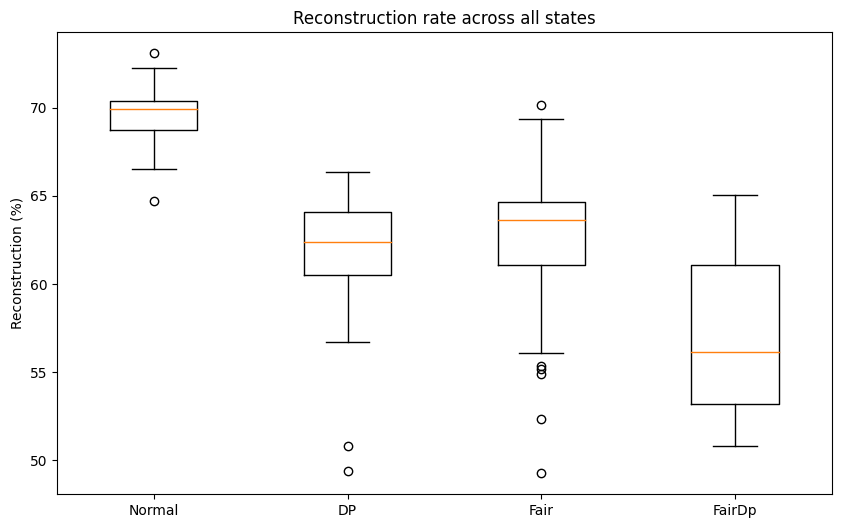

In [46]:

merged_df = pd.DataFrame({
    'inversion_normal_all': inversion_normal_all['Value'],
    'inversion_dp_all': inversion_dp_all['Value'],
    'inversion_fair_all': inversion_fair_all['Value'],
    'inversion_fairdp_all': inversion_fairdp_all['Value']
})

plt.figure(figsize=(10, 6))
plt.boxplot(merged_df.values, labels=['Normal', 'DP',"Fair", "FairDp"])
plt.title('Reconstruction rate across all states')
plt.ylabel("Reconstruction (%)")
plt.show()

In [37]:
# inversion_dp_group_reconstruction

{'AL': {'Male': 54.39642324888227,
  'Female': 58.557537996790344,
  'White': 58.42355502090852,
  'Black': 53.819062293638574}}

In [39]:
df_inversion_normal_group_reconstruction = pd.DataFrame(inversion_normal_group_reconstruction).T
df_inversion_normal_group_reconstruction.index.name = 'State'
df_inversion_normal_group_reconstruction.reset_index(inplace=True)

df_inversion_dp_group_reconstruction = pd.DataFrame(inversion_dp_group_reconstruction).T
df_inversion_dp_group_reconstruction.index.name = 'State'
df_inversion_dp_group_reconstruction.reset_index(inplace=True)

df_inversion_fair_group_reconstruction = pd.DataFrame(inversion_fair_group_reconstruction).T
df_inversion_fair_group_reconstruction.index.name = 'State'
df_inversion_fair_group_reconstruction.reset_index(inplace=True)


df_inversion_fairdp_group_reconstruction = pd.DataFrame(inversion_fairdp_group_reconstruction).T
df_inversion_fairdp_group_reconstruction.index.name = 'State'
df_inversion_fairdp_group_reconstruction.reset_index(inplace=True)




In [40]:
gt_info=pd.read_csv('50_clients_data/state_sex_race_counts.csv')
gt_info.head()

,State,Male_Count,Female_Count,White_Count,Black_Count
0,AL,1038,962,1588,412
1,AK,1129,871,1932,68
2,AZ,1052,948,1912,88
3,AR,1026,974,1807,193
4,CA,1070,930,1856,144


In [41]:
df_inversion_normal_group_reconstruction.head()

,State,Male,Female,White,Black
0,AL,60.901201,65.892571,66.139657,58.397535
1,AK,64.617225,64.027484,68.466350,48.846676
2,AZ,65.003418,66.802642,70.610342,52.400409
3,AR,67.477097,69.684448,72.792603,58.495954
4,CA,64.363294,64.315514,68.908797,53.591863


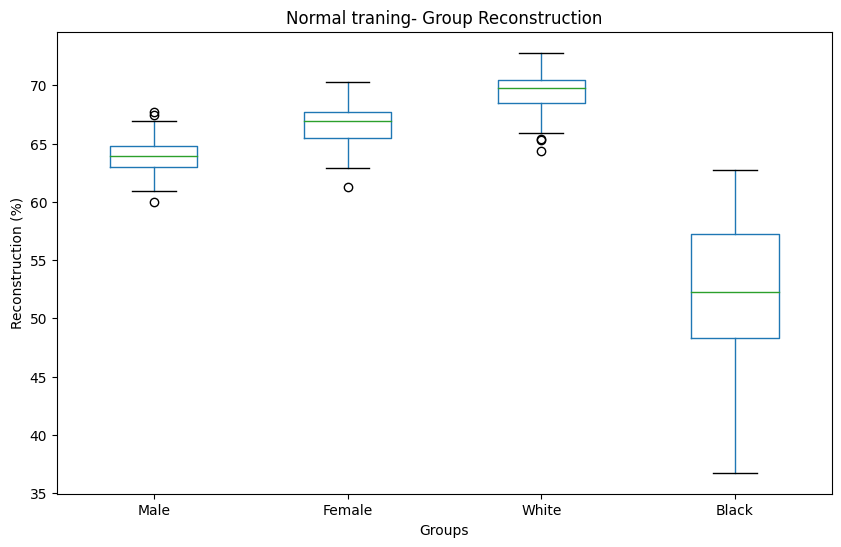

In [42]:
plt.figure(figsize=(10, 6))
df_inversion_normal_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("Normal traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

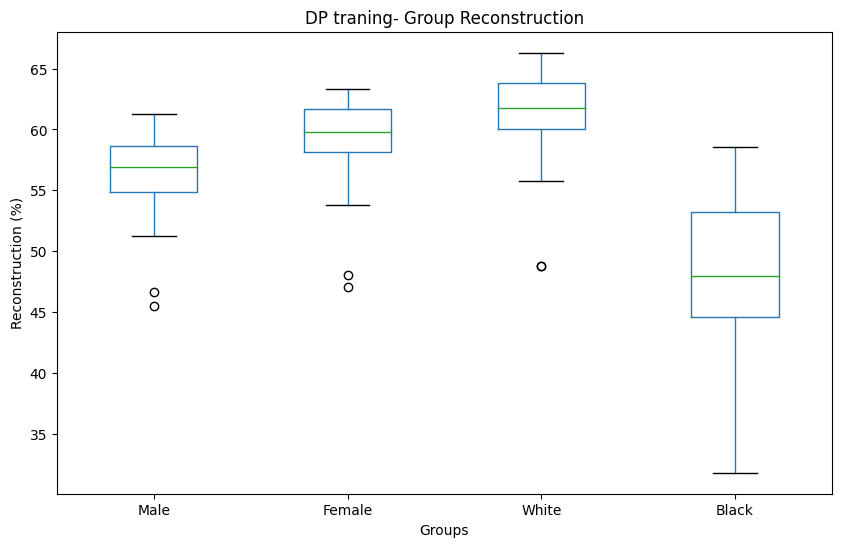

In [43]:

plt.figure(figsize=(10, 6))
df_inversion_dp_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("DP traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

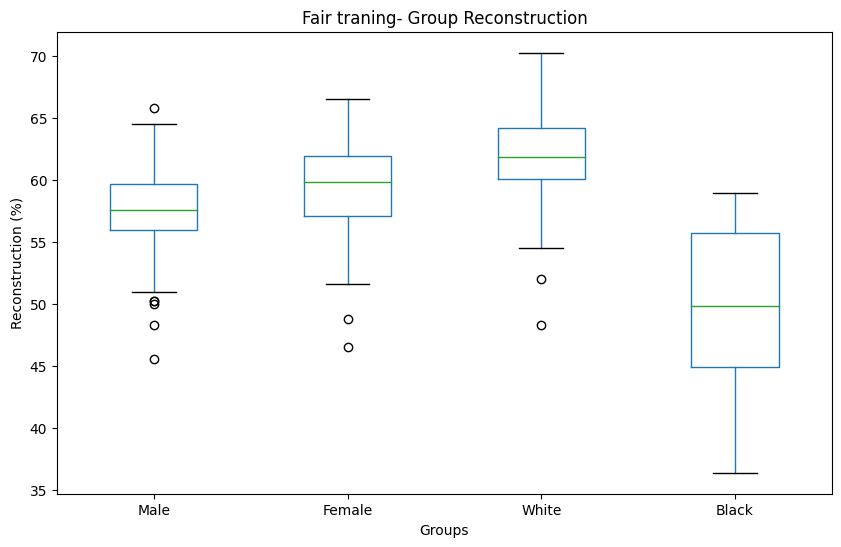

In [44]:

plt.figure(figsize=(10, 6))
df_inversion_fair_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("Fair traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

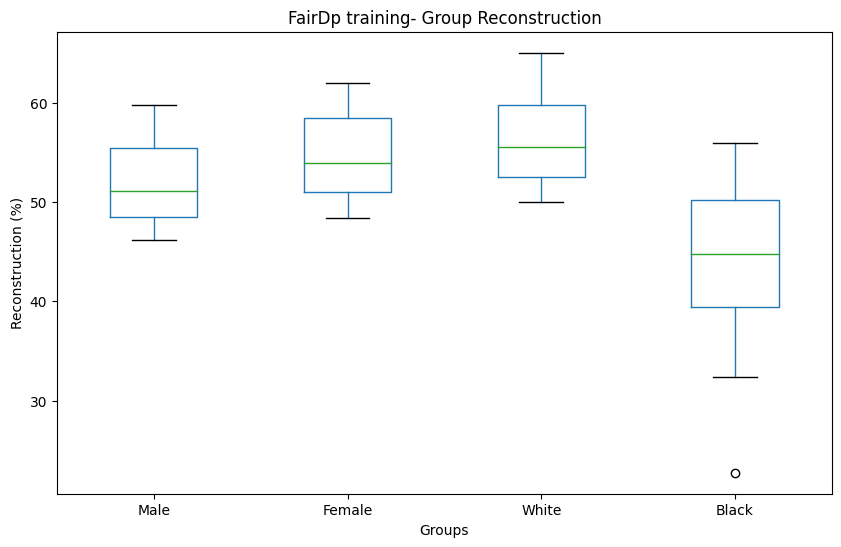

In [47]:

plt.figure(figsize=(10, 6))
df_inversion_fairdp_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("FairDp training- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

In [ ]:
# jupyter nbconvert --to script reconstruct_analysis_both.ipynb
